In [11]:
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
numpyro.enable_x64()    
# posterior samples
import numpy as np
from scipy.stats import norm, gaussian_kde
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
import jax.random as random
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
from datetime import datetime
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

try:
    from scipy.interpolate import PchipInterpolator
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# ---- helper functions ----
def to_datetime(s, fmt=None):
    return pd.to_datetime(s, format=fmt) if fmt else pd.to_datetime(s)

def yoy_pct(series_q):
    # Exact YoY percent change: 100*(x/lag4 - 1)
    return 100 * (series_q / series_q.shift(4) - 1)

def log_yoy(series_q):
    # Log-difference YoY ×100
    return 100 * (np.log(series_q) - np.log(series_q).shift(4))

def resample_quarterly_mean(df, date_col, value_cols):
    x = df.copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()
    q = x.resample("Q").mean()  # quarterly mean
    q.index.freq = "Q"
    return q[value_cols]

def annual_to_quarterly_pchip(df, date_col, value_col):
    """
    Convert annual data to quarterly using PCHIP interpolation.
    Falls back to time/polynomial interpolation if scipy unavailable.
    """
    x = df[[date_col, value_col]].copy()
    x[date_col] = to_datetime(x[date_col])
    x = x.set_index(date_col).sort_index()

    a = x.asfreq("YS")
    q_index = pd.date_range(a.index.min(), a.index.max(), freq="Q")
    q = pd.DataFrame(index=q_index, data=np.nan, columns=[value_col])
    q.index.freq = "Q"
    merged = a.reindex(a.index.union(q.index)).sort_index()

    if _HAS_SCIPY:
        xi = merged.index.view("i8")
        mask = merged[value_col].notna().values
        xx = xi[mask].astype(float)
        yy = merged.loc[mask, value_col].astype(float).values
        if len(xx) >= 2:
            f = PchipInterpolator(xx, yy)
            merged[value_col] = pd.Series(f(xi.astype(float)), index=merged.index)
        else:
            merged[value_col] = merged[value_col].interpolate(method="time")
    else:
        try:
            merged[value_col] = merged[value_col].interpolate(method="time")
            merged[value_col] = merged[value_col].interpolate(method="polynomial", order=3)
        except Exception:
            merged[value_col] = merged[value_col].interpolate()

    return merged.reindex(q_index)

# ---- SPF (xlsx) ----
spf = pd.read_excel("../data/inflation/Inflation.xlsx")
q_month = (spf["QUARTER"] * 3)
spf["DATE"] = pd.to_datetime(
    spf["YEAR"].astype(str) + "-" + q_month.astype(str) + "-01"
) + pd.offsets.MonthEnd(0)
spf["Epi_spf_gdp"] = spf["INFPGDP1YR"]
spf["Epi_spf_cpi"] = spf["INFCPI1YR"]
tt_spf = spf[["DATE", "Epi_spf_gdp", "Epi_spf_cpi"]].set_index("DATE").sort_index()
tt_spf.index = tt_spf.index.to_period("Q").to_timestamp(how="end")
tt_spf.index.freq = "Q"

# ---- CPI headline (monthly → quarterly → YoY%) ----
cpi = pd.read_csv("../data/inflation/CPIAUCSL.csv")
date_col = "DATE" if "DATE" in cpi.columns else ("observation_date" if "observation_date" in cpi.columns else None)
if date_col is None:
    raise ValueError("CPIAUCSL.csv must have DATE or observation_date column.")
tt_cpi_q = resample_quarterly_mean(cpi, date_col, ["CPIAUCSL"])
tt_cpi_q["pi_cpi"] = yoy_pct(tt_cpi_q["CPIAUCSL"])
tt_cpi_q = tt_cpi_q[["pi_cpi"]]

# ---- Core CPI (log YoY) ----
core = pd.read_csv("../data/inflation/CPILFESL.csv")
date_col = "DATE" if "DATE" in core.columns else ("observation_date" if "observation_date" in core.columns else None)
if date_col is None:
    raise ValueError("CPILFESL.csv must have DATE or observation_date column.")
tt_core_m = core[[date_col, "CPILFESL"]].copy()
tt_core_m[date_col] = to_datetime(tt_core_m[date_col])
tt_core_q = tt_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_core_q.index.freq = "Q"
tt_core_q["pi_cpi_core"] = log_yoy(tt_core_q["CPILFESL"])
tt_core = tt_core_q[["pi_cpi_core"]]

# ---- PCE headline (log YoY) ----
pce = pd.read_csv("../data/inflation/PCEPI.csv")
date_col = "DATE" if "DATE" in pce.columns else ("observation_date" if "observation_date" in pce.columns else None)
tt_pce_m = pce[[date_col, "PCEPI"]].copy()
tt_pce_m[date_col] = to_datetime(tt_pce_m[date_col])
tt_pce_q = tt_pce_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_q.index.freq = "Q"
tt_pce_q["pi_pce"] = log_yoy(tt_pce_q["PCEPI"])
tt_pce = tt_pce_q[["pi_pce"]]

# ---- PCE core (log YoY) ----
pce_core = pd.read_csv("../data/inflation/PCEPILFE.csv")
date_col = "DATE" if "DATE" in pce_core.columns else ("observation_date" if "observation_date" in pce_core.columns else None)
tt_pce_core_m = pce_core[[date_col, "PCEPILFE"]].copy()
tt_pce_core_m[date_col] = to_datetime(tt_pce_core_m[date_col])
tt_pce_core_q = tt_pce_core_m.set_index(date_col).sort_index().resample("Q").mean()
tt_pce_core_q.index.freq = "Q"
tt_pce_core_q["pi_pce_core"] = log_yoy(tt_pce_core_q["PCEPILFE"])
tt_pce_core = tt_pce_core_q[["pi_pce_core"]]

# ---- N (annual → quarterly, cubic interp) ----
hhi = pd.read_csv("../data/competition/BN_N_26.csv")
hhi["N"] = hhi["original_series"]
hhi["year"] = pd.to_datetime(pd.to_datetime(hhi["date"]).dt.year.astype(str) + "-01-01")
tt_hhi_q = annual_to_quarterly_pchip(hhi.rename(columns={"year": "DATE"}), "DATE", "N")
# ---- N cycle and trend (annual → quarterly, cubic interp) ----
nb = pd.read_csv("../data/competition/BN_N_26.csv")
nb["N_BN_cycle"] = nb["cycle"]
nb["N_BN_trend"] = nb["trend"]
nb["DATE"] = pd.to_datetime(pd.to_datetime(nb["date"]).dt.year.astype(str) + "-01-01")
nb = nb[["DATE", "N_BN_cycle","N_BN_trend"]].dropna()
tt_nb_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_cycle")
tt_nb_trend_q = annual_to_quarterly_pchip(nb, "DATE", "N_BN_trend")

# ---- Markup levels ----
mk = pd.read_excel("../data/markup/nekarda_ramey_markups.xlsx")
mk["DATE"] = to_datetime(mk["qdate"])
mk["markup"] = mk["mu_bus"]
tt_mk = mk[["DATE", "markup"]].dropna().set_index("DATE").sort_index()
tt_mk.index = tt_mk.index.to_period("Q").to_timestamp(how="end")
tt_mk.index.freq = "Q"

# ---- BN inverse markup ----
mk_bn = pd.read_csv("../data/markup/BN_markup_inv.csv")
mk_bn["markup_BN_inv"] = mk_bn["cycle"]
mk_bn["DATE"] = to_datetime(mk_bn["date"])
tt_mk_bn = mk_bn[["DATE", "markup_BN_inv"]].dropna().set_index("DATE").sort_index()
tt_mk_bn.index = tt_mk_bn.index.to_period("Q").to_timestamp(how="end")
tt_mk_bn.index.freq = "Q"

# ---- Employment gap (NROU - UNRATENSA) ----
nairu = pd.read_csv("../data/unemp_gap/NROU.csv")
unemp = pd.read_csv("../data/unemp_gap/UNRATENSA.csv")

dc1 = "DATE" if "DATE" in nairu.columns else "observation_date"
dc2 = "DATE" if "DATE" in unemp.columns else "observation_date"

# Make sure both DATE columns are real datetimes (on both sides!)
n = nairu[[dc1, "NROU"]].rename(columns={dc1: "DATE"})
u = unemp[[dc2, "UNRATENSA"]].rename(columns={dc2: "DATE"})
n["DATE"] = pd.to_datetime(n["DATE"], errors="coerce")
u["DATE"] = pd.to_datetime(u["DATE"], errors="coerce")

tt_gap = (
    n.merge(u, on="DATE", how="outer")
     .set_index("DATE")
     .sort_index()
     .resample("Q").mean()
)
tt_gap.index.freq = "Q"
tt_gap["unemp_gap"] = tt_gap["NROU"] - tt_gap["UNRATENSA"]
tt_gap = tt_gap[["unemp_gap"]].dropna()

# ---- Output gap data (BN filter) ----
out = pd.read_csv("../data/output_gap/BN_filter_GDPC1_quaterly.csv")
out["output_BN"] = out["GDPC1_transformed_series"]
out["output_gap_BN"] = out["cycle"]
out["output"] = np.log(out["GDPC1_original_series"] * 0.01)
out["DATE"] = to_datetime(out["date"])
out["output_trend_BN"] = out["output_BN"] - out["output_gap_BN"]
tt_out = (
    out[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]]
    .dropna()
    .set_index("DATE")
    .sort_index()
)
tt_out.index = tt_out.index.to_period("Q").to_timestamp(how="end")
tt_out.index.freq = "Q"

# ---- Oil prices (WTI deflated by CPI, log YoY) ----
oil = pd.read_csv("../data/others/WTISPLC_CPIAUCSL.csv")
dc = "DATE" if "DATE" in oil.columns else "observation_date"
tt_oil = oil[[dc, "WTISPLC_CPIAUCSL"]].copy()
tt_oil[dc] = to_datetime(tt_oil[dc])
tt_oil = tt_oil.set_index(dc).sort_index().resample("Q").mean()
tt_oil.index.freq = "Q"
tt_oil["log_oil"] = np.log(tt_oil["WTISPLC_CPIAUCSL"])
tt_oil["oil"] = tt_oil["log_oil"] - tt_oil["log_oil"].shift(4)
tt_oil = tt_oil[["oil"]]

# ---- Inflation expectations (monthly → quarterly mean ×100) ----
epi = pd.read_csv("../data/inflation/one_year_inflation_expectation.csv")
epi["DATE"] = to_datetime(epi["Date"], fmt="%Y-%m-%d")
epi.astype({"DATE": str}).set_index("DATE", inplace=True)
epi["Epi"] = epi[" Epi"] * 100
epi = epi[["DATE","Epi"]]
tt_epi_m = pd.DataFrame({"DATE": epi["DATE"], "Epi": epi["Epi"]}).set_index("DATE").sort_index()
tt_epi = tt_epi_m.resample("Q").mean()

def as_qe_midnight(df):
    """Force index to quarter-start at 00:00:00 (no nanoseconds)."""
    out = df.copy()
    # ensure datetime index
    out.index = pd.to_datetime(out.index)
    # convert to quarter periods then back to Timestamps at end-of-quarter
    out.index = pd.PeriodIndex(out.index, freq="Q").to_timestamp(how="end").normalize()
    out.index.name = "DATE"
    # freq is not needed; leave it unset to avoid surprises
    out.index.freq = None
    return out
dfs = [
    tt_cpi_q, tt_epi, tt_spf, tt_core, tt_out, tt_hhi_q, tt_nb_q,tt_nb_trend_q,
    tt_mk, tt_pce_core, tt_pce, tt_mk_bn, tt_gap, tt_oil
]
dfs = [as_qe_midnight(d) for d in dfs] 
data = pd.concat(dfs, axis=1).sort_index()

data.index = data.index.to_period("Q").to_timestamp(how="end")
data.index.freq = "Q"

# ---- Add lagged variables ----
for col in ["pi_cpi", "pi_cpi_core", "pi_pce", "pi_pce_core"]:
    if col in data.columns:
        data[f"{col}_prev"] = data[col].shift(1)

    
# data = data.loc["1982-01-01":"2012-12-31"]
data['DATE'] = pd.to_datetime(data.index)

import pandas as pd
import statsmodels.api as sm

y = data["pi_cpi"].dropna()
X = pd.DataFrame({
    "pi_prev": data["pi_cpi_prev"],
    "Epi": data["Epi_spf_cpi"],
    "x1": data["output_gap_BN"],
    "x2": data["unemp_gap"],
    "x3": data["markup_BN_inv"],
    "Nhat": data["N_BN_cycle"],
    "oil": data["oil"]
})
df = pd.concat([y, X], axis=1).dropna()
periods = [
    ("1982-01-01", "2012-12-31"),
]

results = {}
for i, (start, end) in enumerate(periods, 1):
    sub = df.loc[start:end]
    Y = sub["pi_cpi"]
    X = sub[["pi_prev", "Epi", "x1", "x2","x3", "Nhat"]]
    model = sm.OLS(Y, X).fit()
    results[f"Period {i}: {start}–{end}"] = model

for label, res in results.items():
    print(f"\n===== {label} =====")
    print(res.summary())


===== Period 1: 1982-01-01–2012-12-31 =====
                                 OLS Regression Results                                
Dep. Variable:                 pi_cpi   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              519.1
Date:                Mon, 10 Nov 2025   Prob (F-statistic):                    2.56e-82
Time:                        17:55:00   Log-Likelihood:                         -119.89
No. Observations:                 124   AIC:                                      251.8
Df Residuals:                     118   BIC:                                      268.7
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.9

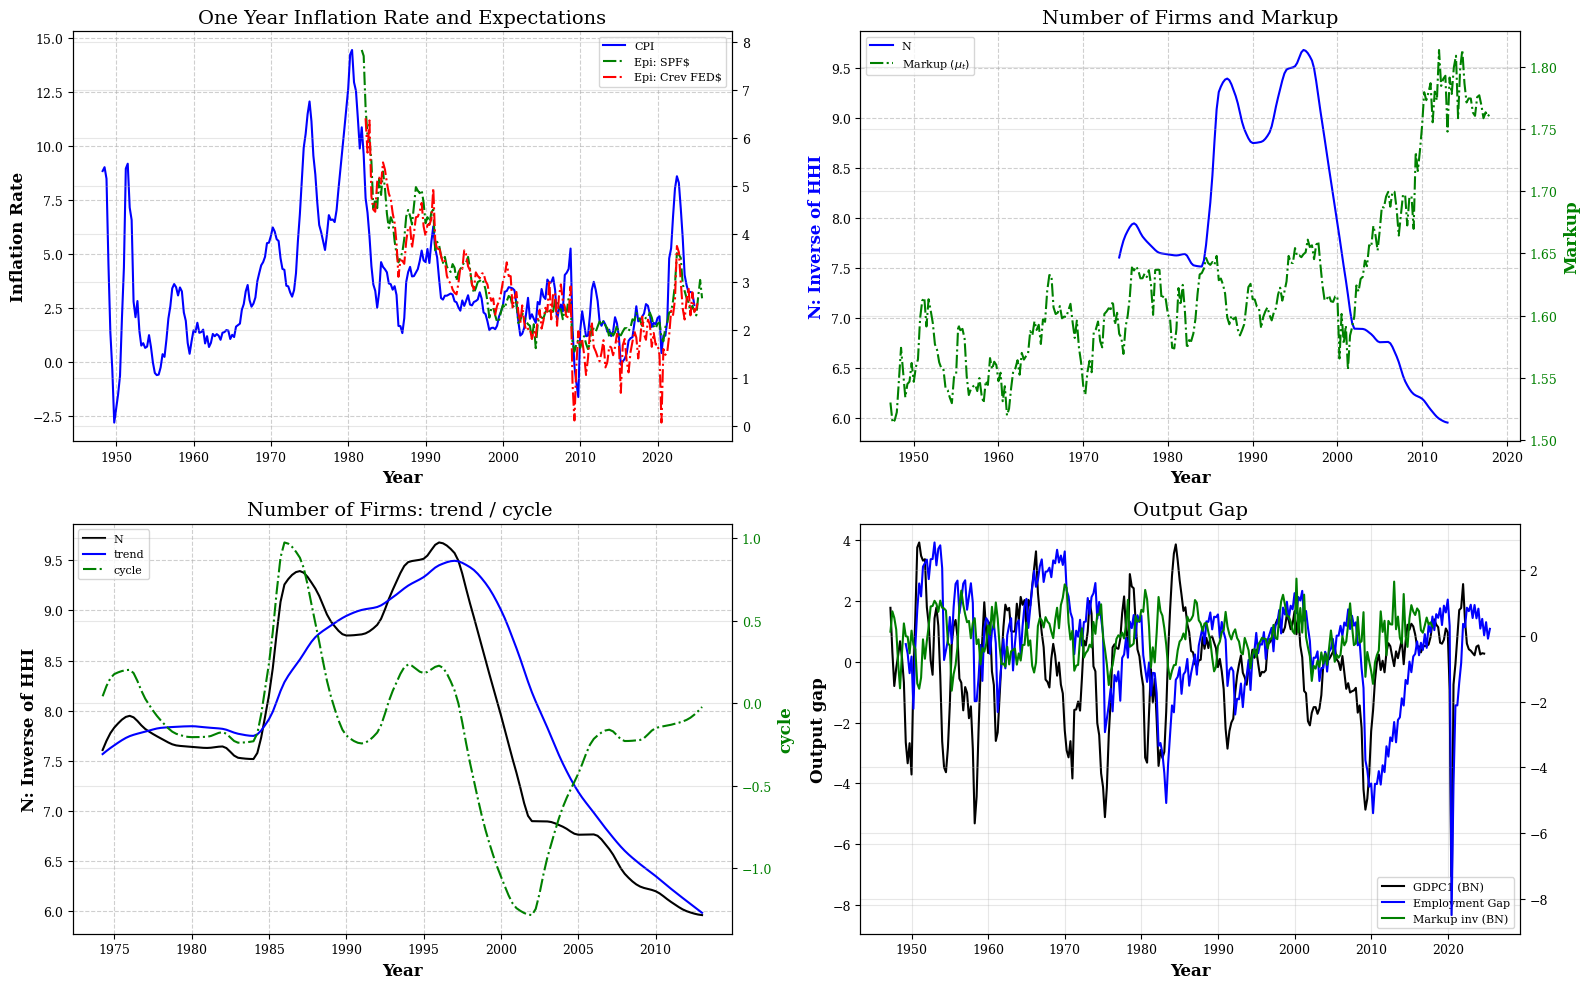

In [2]:
# --- 2×2 graph ---
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# --- 1. Inflation and Expected Inflation ---
ax1= axs[0, 0]
ax1_left = ax1
ax1_right = ax1_left.twinx()
ax1_left.plot(data["DATE"], data["pi_cpi"], label=r'CPI', color='blue')
ax1_right.plot(data["DATE"], data["Epi_spf_cpi"], label=r'Epi: SPF$', linestyle='-.', color='green')
ax1_right.plot(data["DATE"], data["Epi"], label=r'Epi: Crev FED$', linestyle='-.', color='red')
ax1_left.set_xlabel('Year', fontsize=12, weight='bold')
ax1_left.set_ylabel('Inflation Rate', fontsize=12, weight='bold', color = 'black')
ax1_left.grid(True, linestyle='--', alpha=0.6)
ax1_left.set_title('One Year Inflation Rate and Expectations', fontsize=14)
lines = ax1_left.get_lines() + ax1_right.get_lines()
labels = [line.get_label() for line in lines]
ax1_left.legend(lines, labels, loc='upper right', fontsize=8)

# --- 2. Number of Firms and Markup ---
ax2 = axs[0, 1]
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'N', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12, weight='bold')
ax2_left.set_ylabel('N: Inverse of HHI', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Number of Firms and Markup', fontsize=14)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 3.  Number of Firms: trend / cycle ---
ax3 = axs[1, 0]
ax3_left = ax3
ax3_right = ax3_left.twinx()
ax3_left.plot(data["DATE"], data["N"], label='N', color='black')
ax3_left.plot(data["DATE"], data["N_BN_trend"], label='trend', color='blue')
ax3_right.plot(data["DATE"],data["N_BN_cycle"], label=r'cycle', linestyle='-.', color='green')
ax3_left.set_xlabel('Year', fontsize=12, weight='bold')
ax3_left.set_ylabel('N: Inverse of HHI', fontsize=12, weight='bold')
ax3_right.set_ylabel('cycle', fontsize=12, weight='bold', color='green')
ax3_right.tick_params(axis='y', labelcolor='green')
ax3_left.grid(True, linestyle='--', alpha=0.6)
ax3_left.set_title('Number of Firms: trend / cycle ', fontsize=14)
lines = ax3_left.get_lines() + ax3_right.get_lines()
labels = [line.get_label() for line in lines]
ax3_left.legend(lines, labels, loc='upper left', fontsize=8)

# --- 5. Output Gaps ------
ax5 = axs[1, 1]
ax5_left = ax5
ax5_right = ax5_left.twinx()
ax5_left.set_ylabel('Output gap', fontsize=12, weight='bold', color='black')
ax5_left.plot(data["DATE"], data["output_gap_BN"], label=r'GDPC1 (BN)', color='black')
ax5_right.plot(data["DATE"], data["unemp_gap"], label=r'Employment Gap', color='blue')
ax5_right.plot(data["DATE"], data["markup_BN_inv"], label=r'Markup inv (BN)', color='green')
ax5_left.set_title('Output Gap', fontsize=14)
ax5_left.set_xlabel('Year', fontsize=12, weight='bold')
lines = ax5_left.get_lines() + ax5_right.get_lines()
labels = [line.get_label() for line in lines]
ax5_left.legend(lines, labels, loc='lower right', fontsize=8)
# --- Layout ---
plt.tight_layout()
plt.show()

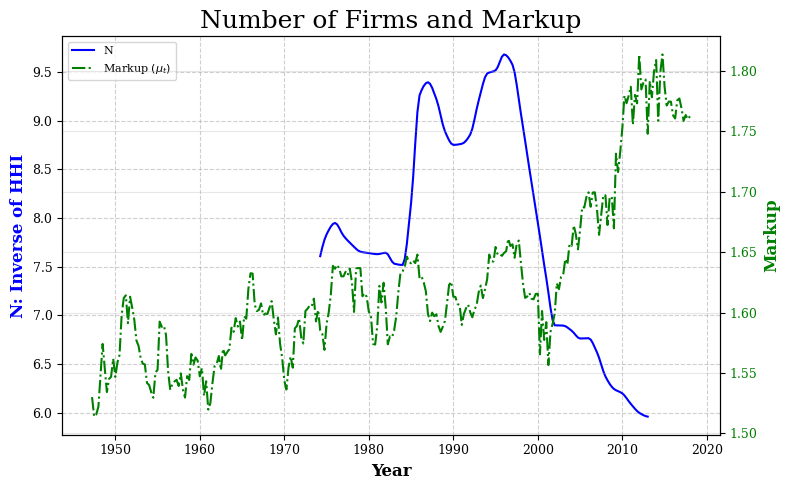

In [3]:
# --- 2. Number of Firms and Markup ---
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
ax2 = axs
ax2_left = ax2
ax2_right = ax2_left.twinx()
ax2_left.plot(data["DATE"], data["N"], label=r'N', color='blue')
ax2_right.plot(data["DATE"], data["markup"], label=r'Markup $(\mu_{t})$', linestyle='-.', color='green')
ax2_left.set_xlabel('Year', fontsize=12,weight='bold')
ax2_left.set_ylabel('N: Inverse of HHI', fontsize=12, weight='bold', color = 'blue')
ax2_right.set_ylabel('Markup', fontsize=12, weight='bold', color='green')
ax2_right.tick_params(axis='y', labelcolor='green')
ax2_left.grid(True, linestyle='--', alpha=0.6)
ax2_left.set_title('Number of Firms and Markup', fontsize=18)
lines = ax2_left.get_lines() + ax2_right.get_lines()
labels = [line.get_label() for line in lines]
ax2_left.legend(lines, labels, loc='upper left', fontsize=8)
# --- Layout ---
plt.tight_layout()
plt.show()